<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# Feed Forward Networks (Part 1)#
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

### imports and graphics configurations ###

In [ ]:
import torch
import numpy
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import graphviz
import itertools
import time

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

### configuration variables###

In [ ]:
SEED=0
N_points=100

In [ ]:
x_min=-3
x_max=3
markersize=5
thinlinewidth=2
textboxsize=(5,0.5)

## Generate training data in the plane ##

points in the right-half plane will have label 1
points in the left-half plane will have label 0

In [ ]:
xy=scipy.stats.norm.rvs(size=(N_points,2),random_state=SEED)

In [ ]:
flags=xy[:,0]>0
xy=numpy.array(xy,dtype=numpy.float32)
z=numpy.array(flags,dtype=numpy.float32).reshape(-1,1)

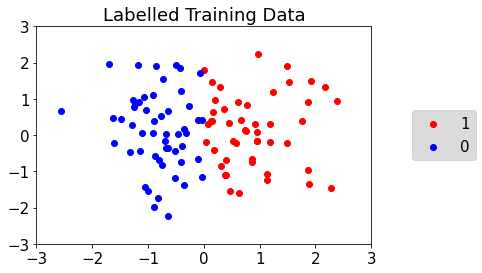

In [ ]:
plt.figure()
plt.scatter(xy[flags,0],xy[flags,1],color="red",label="1")
plt.scatter(xy[~flags,0],xy[~flags,1],color="blue",label="0")
plt.xlim(x_min,x_max)
plt.ylim(x_min,x_max)
title=[]
title.append("Labelled Training Data")
plt.title("\n".join(title))
legend("side")
#saver("tt_123")
plt.show()
plt.close()

feature-label pairs $\left\{((x_n,y_n),z_n)\right\}_{n=1}^N\subset R^2\times \{0,1\}$.
Sigmoid function is
$$S(z)=\frac{1}{1+e^{-z}}$$
Model is
$$ S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} + B^{(1)}\right)+B^{(2)}\right)$$
where
* $M^{(1)}\in R^{2\times 2}$
* $B^{(1)}\in R^2$
* $M^{(2)}\in R^{1\times 2}$
* $B^{(2)}\in R$


We have
$$ a_1=M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} + B^{(1)}$$
$$ a_2=M^{(2)}S(a_1)+B^{(2)}$$



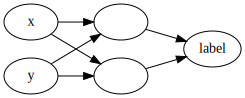

In [ ]:
g=graphviz.Digraph()
g.attr(rankdir='LR')
features=["x","y"]
for feature in features:
    g.node(feature)
a1=["a11","a12"]
for node in a1:
    g.node(node,label="")
for f,node in itertools.product(features,a1):
    g.edge(f,node)
labels=["label"]
for label in labels:
    g.node(label)
for (i2,l) in itertools.product(a1,labels):
    g.edge(i2,l)

g

In [ ]:
inputs=torch.from_numpy(xy)
labels=torch.from_numpy(z)

if torch.cuda.is_available():
    print("cuda is available")
    inputs = inputs.cuda()
    labels = labels.cuda()

In [ ]:
class SimpleFeedForward(torch.nn.Module):
    def __init__(self): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        self.linear1 = torch.nn.Linear(2,2)
        self.linear2 = torch.nn.Linear(2,1)
        self.sigmoid=torch.nn.Sigmoid()

    def forward(self, x):
        out=self.linear1(x) #a1
        out=self.sigmoid(out)
        out=self.linear2(out) #a2
        out=self.sigmoid(out)
        return out

In [ ]:
def explore_initial_weights(initialweights,learningRate=1,MAX_iter=1000):
  torch.manual_seed(SEED) #initialize for reproducibility
  model=SimpleFeedForward()
  model.linear1.weight.data=torch.from_numpy(numpy.array(initialweights,dtype=numpy.float32))
  model = model.cuda() if torch.cuda.is_available() else model
  Loss = torch.nn.BCELoss()
  losses=[]
  errors=[]
  optimizer = torch.optim.SGD(model.parameters(), lr=learningRate) #gradient descent
  tic=time.perf_counter()
  for ctr in range(MAX_iter):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    lossvalue = Loss(outputs, labels)
    error=(outputs>0.5)!=(labels==1)
    errors.append(torch.sum(error)/len(error))
    losses.append(lossvalue)

    # get gradients w.r.t to parameters
    lossvalue.backward()
    #print(model.linear.weight.grad.item(),model.linear.bias.grad.item())

    # update parameters
    optimizer.step()
    if ctr%int(MAX_iter/10)==0: #print out data for 10 intermediate steps
      print("iteration {}: loss={:.5f}".format(ctr, lossvalue.item()))
  toc=time.perf_counter()

  print("\n")
  print("M^{(1)}=\n",model.linear1.weight.data.cpu().numpy(),"\nB^{(1)}=",model.linear1.bias.data.cpu().numpy())
  print("\n")
  print("M^{(2)}=\n",model.linear2.weight.data.cpu().numpy(),"\nB^{(2)}=",model.linear2.bias.data.cpu().numpy())
  dt=toc-tic


  return model,losses,errors,dt

In [ ]:
def visualizer(model,losses,errors,dt):
  outputs=model(inputs)>0.5
  flags_correct=(labels==1)==outputs
  accuracy=torch.sum(flags_correct)/len(flags_correct)
  flags=outputs.cpu().flatten()
  plt.figure()
  plt.scatter(xy[flags,0],xy[flags,1],color="red",label="1")
  plt.scatter(xy[~flags,0],xy[~flags,1],color="blue",label="0")
  title=[]
  title.append("Computed Labels on Training Data")
  title.append("Accuracy={:.1%}".format(accuracy))
  plt.title("\n".join(title))
  plt.xlim(x_min,x_max)
  plt.ylim(x_min,x_max)
  legend("side")
  #saver("tt_123")
  plt.show()
  plt.close()

  plt.figure()
  plt.plot(losses,color="red")
  plt.xlabel("Iteration")
  plt.ylabel("loss")
  plt.ylim(-0.1,)
  title=[]
  title.append("Losses")
  title.append("Elapsed time: {0:.02f} seconds".format(dt))
  plt.title("\n".join(title))
  plt.axhline(0,linewidth=2,linestyle=":",color="black")
  plt.show()
  plt.close()

  plt.figure()
  plt.plot(errors,color="red")
  plt.xlabel("Iteration")
  plt.ylabel("percent wrong")
  plt.ylim(-0.05,)
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
  plt.axhline(0,linewidth=2,linestyle=":",color="black")
  title=[]
  title.append("Classification Errors")
  title.append("Elapsed time: {0:.02f} seconds".format(dt))
  plt.title("\n".join(title))
  plt.show()
  plt.close()

In [ ]:
m,losses,errors,dt=explore_initial_weights([[1,0],[0,0]])

iteration 0: loss=0.70626
iteration 100: loss=0.11482
iteration 200: loss=0.06561
iteration 300: loss=0.04950
iteration 400: loss=0.04106
iteration 500: loss=0.03567
iteration 600: loss=0.03184
iteration 700: loss=0.02893
iteration 800: loss=0.02661
iteration 900: loss=0.02471


M^{(1)}=
 [[7.3803663  0.17430976]
 [5.8089223  0.16463237]] 
B^{(1)}= [-0.2834577  -0.31137228]


M^{(2)}=
 [[8.187166  5.9930267]] 
B^{(2)}= [-6.2865605]


First layer: approximately
$$S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix}+B^{(1)}\right)\approx \begin{pmatrix} s_\varepsilon(x)\\ s_\varepsilon(x)\end{pmatrix}$$
with $\varepsilon\approx 1/6$.

Second layer:  approximately
$$S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} +B^{(1)}\right)+B^{(2)}\right)\approx S(8.2s_\varepsilon(x)+6.0s_\varepsilon(x)-6.3)\\
\approx s_{\varepsilon'}(s_\varepsilon(x)-0.44)$$
with $\varepsilon'=1/14.2$


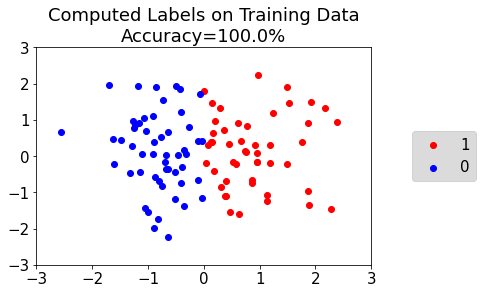

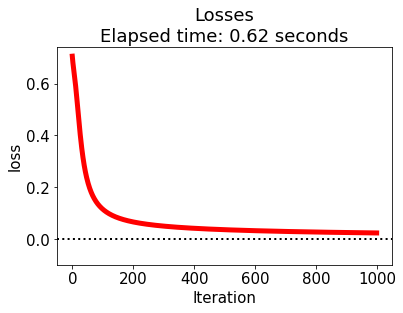

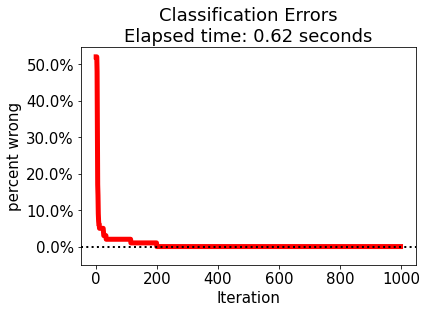

In [ ]:
visualizer(m,losses,errors,dt)

In [ ]:
m,losses,errors,dt=explore_initial_weights([[0,0],[1,0]])

iteration 0: loss=0.65432
iteration 100: loss=0.09782
iteration 200: loss=0.05713
iteration 300: loss=0.04368
iteration 400: loss=0.03649
iteration 500: loss=0.03183
iteration 600: loss=0.02847
iteration 700: loss=0.02589
iteration 800: loss=0.02383
iteration 900: loss=0.02212


M^{(1)}=
 [[-4.7302914  -0.14614445]
 [ 7.794597    0.16936654]] 
B^{(1)}= [ 0.09903392 -0.13645442]


M^{(2)}=
 [[-5.6757994  9.608388 ]] 
B^{(2)}= [-1.7539653]


First layer: approximately
$$S\left(M^{(1)}\begin{pmatrix}x\\ y\end{pmatrix}+B^{(1)}\right)\approx \begin{pmatrix} s_\varepsilon(-x)\\ s_\varepsilon(x)\end{pmatrix}$$.

Second layer:  approximately
$$S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x\\ y\end{pmatrix}+B^{(1)}\right)+B^{(2)}\right)\approx S(-5.7s_\varepsilon(-x)+9.6s_\varepsilon(x)-1.7)\\
\approx S(-5.7+5.7s_\varepsilon(x)+9.6s_\varepsilon(x)-1.7)\\
=S(15.3s_\varepsilon(x)-7.4)\\
=s_{\varepsilon'}(s_\varepsilon(x)-0.48)$$
with $\varepsilon'=1/15.3$


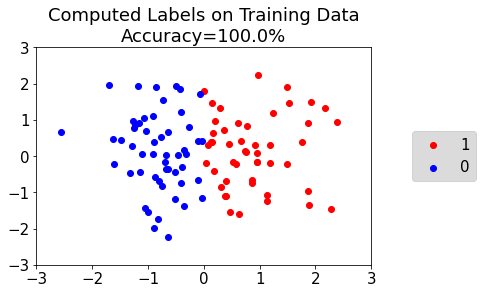

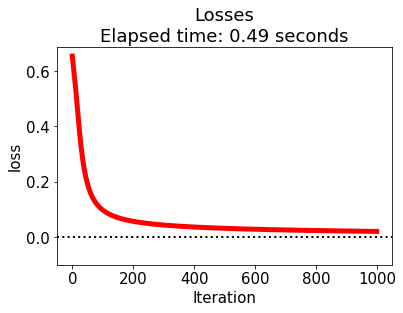

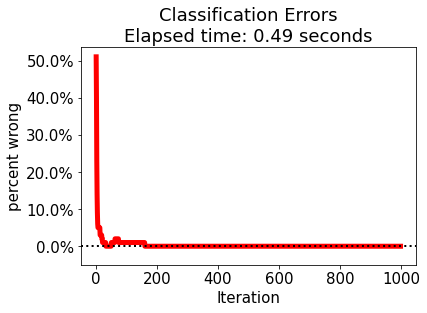

In [ ]:
visualizer(m,losses,errors,dt)